![paleoCAMP logo](./images/paleoCAMPLogo.png)

# 6. More Info: iCESM and iTRACE analysis

**Tutorials at [the 2025 paleoCAMP](https://paleoclimate.camp/) | June 16–June 30, 2025**
       
[Jiang Zhu](https://staff.cgd.ucar.edu/jiangzhu/)  
[jiangzhu@ucar.edu](mailto:jiangzhu@ucar.edu)  
Climate & Global Dynamics Laboratory  
NSF National Center for Atmospheric Research    

------

**More information and examples to demonstrate iCESM and iTRACE analysis using the NCAR JupyterHub**
* Compute and plot precipitation δ18O
* Plot AMOC from TraCE and compare with McManus et al. 2004
* Postprocess annual mean δ18O from iTRACE

**Time to go through**: 15 minutes

---
Load Python packages

In [1]:
import os
import glob
from datetime import timedelta

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# xesmf is used for regridding ocean output
import xesmf

import warnings
warnings.filterwarnings("ignore")

---
## Compute and plot precipitation δ18O
- We define a function to compute precipitation δ18O

In [2]:
def calculate_d18Op(ds):
    """
    Compute precipitation δ18O with iCESM output

    Parameters
    ds: xarray.Dataset contains necessary variables

    Returns
    ds: xarray.Dataset with δ18O added
    """

    # convective & large-scale rain and snow, respectively
    p16O = ds.PRECRC_H216Or + ds.PRECSC_H216Os + ds.PRECRL_H216OR + ds.PRECSL_H216OS # total mass of water containing oxygen-16
    p18O = ds.PRECRC_H218Or + ds.PRECSC_H218Os + ds.PRECRL_H218OR + ds.PRECSL_H218OS # total mass of water containing oxygen-18

    p16O = xr.where(p16O > 1.E-18, p16O, 1.E-18) # make sure there are no tiny values that will blow up the ratio calculation
    p18O = xr.where(p16O > 1.E-18, p18O, 1.E-18) # keep consistency with the above treatment for p16O
    d18O = (p18O / p16O - 1.0) * 1000.0 # calculate the delta value - the ratio of (18O/16O - 1) * 1000!

    # store the new variables as xarray variables

    ds['d18O'] = d18O
    ds['p18O'] = p18O
    ds['p16O'] = p16O

    return ds

- Figure out the file names

In [3]:
!ls /glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/*PRECRC_H218Or*
!ls /glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.i21ka.03/atm/proc/tseries/month_1/*PRECRC_H218Or*

/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRC_H218Or.0001-0900.cal_adj.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRC_H218Or.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.i21ka.03/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.i21ka.03.cam.h0.PRECRC_H218Or.0001-0900.cal_adj.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.i21ka.03/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.i21ka.03.cam.h0.PRECRC_H218Or.0001-0900.nc


* We need to read in all these variables

In [4]:
vnames = ['PRECC', 'PRECL',
          'PRECRC_H216Or', 'PRECSC_H216Os', 'PRECRL_H216OR', 'PRECSL_H216OS',
          'PRECRC_H218Or', 'PRECSC_H218Os', 'PRECRL_H218OR', 'PRECSL_H218OS']

In [5]:
storage_dir = '/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/'
hist_dir = '/atm/proc/tseries/month_1/'

case_pre = 'b.e12.B1850C5.f19_g16.iPI.01'
case_lgm = 'b.e12.B1850C5.f19_g16.i21ka.03'

fnames_pre = []
fnames_lgm = []

for vname in vnames:

    fname = glob.glob(storage_dir + case_pre + hist_dir + '*' + vname + '.0001-0900.nc')
    fnames_pre.extend(fname)

    fname = glob.glob(storage_dir + case_lgm + hist_dir + '*' + vname + '.0001-0900.nc')
    fnames_lgm.extend(fname)

print(*fnames_pre, sep='\n')
print(*fnames_lgm, sep='\n')

/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECC.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECL.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRC_H216Or.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECSC_H216Os.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRL_H216OR.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECSL_H216OS.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g1

In [6]:
%%time

ds_pre = xr.open_mfdataset(fnames_pre, parallel=True,
                           data_vars='minimal',
                           coords='minimal',
                           compat='override',
                           chunks={'time':12}).isel(time=slice(-120, None))

ds_lgm = xr.open_mfdataset(fnames_lgm, parallel=True,
                           data_vars='minimal',
                           coords='minimal',
                           compat='override',
                           chunks={'time':12}).isel(time=slice(-120, None))

CPU times: user 1.5 s, sys: 200 ms, total: 1.7 s
Wall time: 5.24 s


In [7]:
ds_pre = calculate_d18Op(ds_pre)
ds_lgm = calculate_d18Op(ds_lgm)
ds_pre

<xarray.Dataset> Size: 73MB
Dimensions:        (lev: 30, ilev: 31, lat: 96, lon: 144, slat: 95, slon: 144,
                    time: 120, nbnd: 2)
Coordinates:
  * lev            (lev) float64 240B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 248B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * lat            (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon            (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 760B -89.05 -87.16 -85.26 ... 87.16 89.05
  * slon           (slon) float64 1kB -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
  * time           (time) object 960B 0891-02-01 00:00:00 ... 0901-01-01 00:0...
Dimensions without coordinates: nbnd
Data variables: (12/42)
    hyam           (lev) float64 240B dask.array<chunksize=(30,), meta=np.ndarray>
    hybm           (lev) float64 240B dask.array<chunksize=(30,), meta=np.ndarray>
    hyai           (ilev) float64 248B dask.array<chunksize=(31,), meta=np.ndarray>
    hybi           (ilev) float64 248B dask.array<chunksize=(31,), meta=np.ndarray>
    P0             float64 8B ...
    w_stag         (slat) float64 760B dask.array<chunksize=(95,), meta=np.ndarray>
    ...             ...
    PRECRL_H218OR  (time, lat, lon) float32 7MB dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    PRECSC_H216Os  (time, lat, lon) float32 7MB dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    PRECSC_H218Os  (time, lat, lon) float32 7MB dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    PRECSL_H216OS  (time, lat, lon) float32 7MB dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    PRECSL_H218OS  (time, lat, lon) float32 7MB dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    d18O           (time, lat, lon) float32 7MB dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e12.B1850C5.f19_g16.iPI.01
    title:            UNSET
    logname:          jiangzhu
    host:             r5i1n15
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850C5CN.f19_g16.09.cam.i.0401-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

In [8]:
# Save netcdf data
# ds_pre.to_netcdf('dataset_with_d18Op.nc')

In [9]:
d18Op_pre = ds_pre.d18O.mean('time')
d18Op_lgm = ds_lgm.d18O.mean('time')

# Sometimes, it is preferred to use the precipitation-amount weighted d18O
#d18Op_pre = ds_pre.d18O.weighted(ds_pre.p16O).mean('time')

d18Op_pre

<xarray.DataArray 'd18O' (lat: 96, lon: 144)> Size: 55kB
dask.array<mean_agg-aggregate, shape=(96, 144), dtype=float32, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

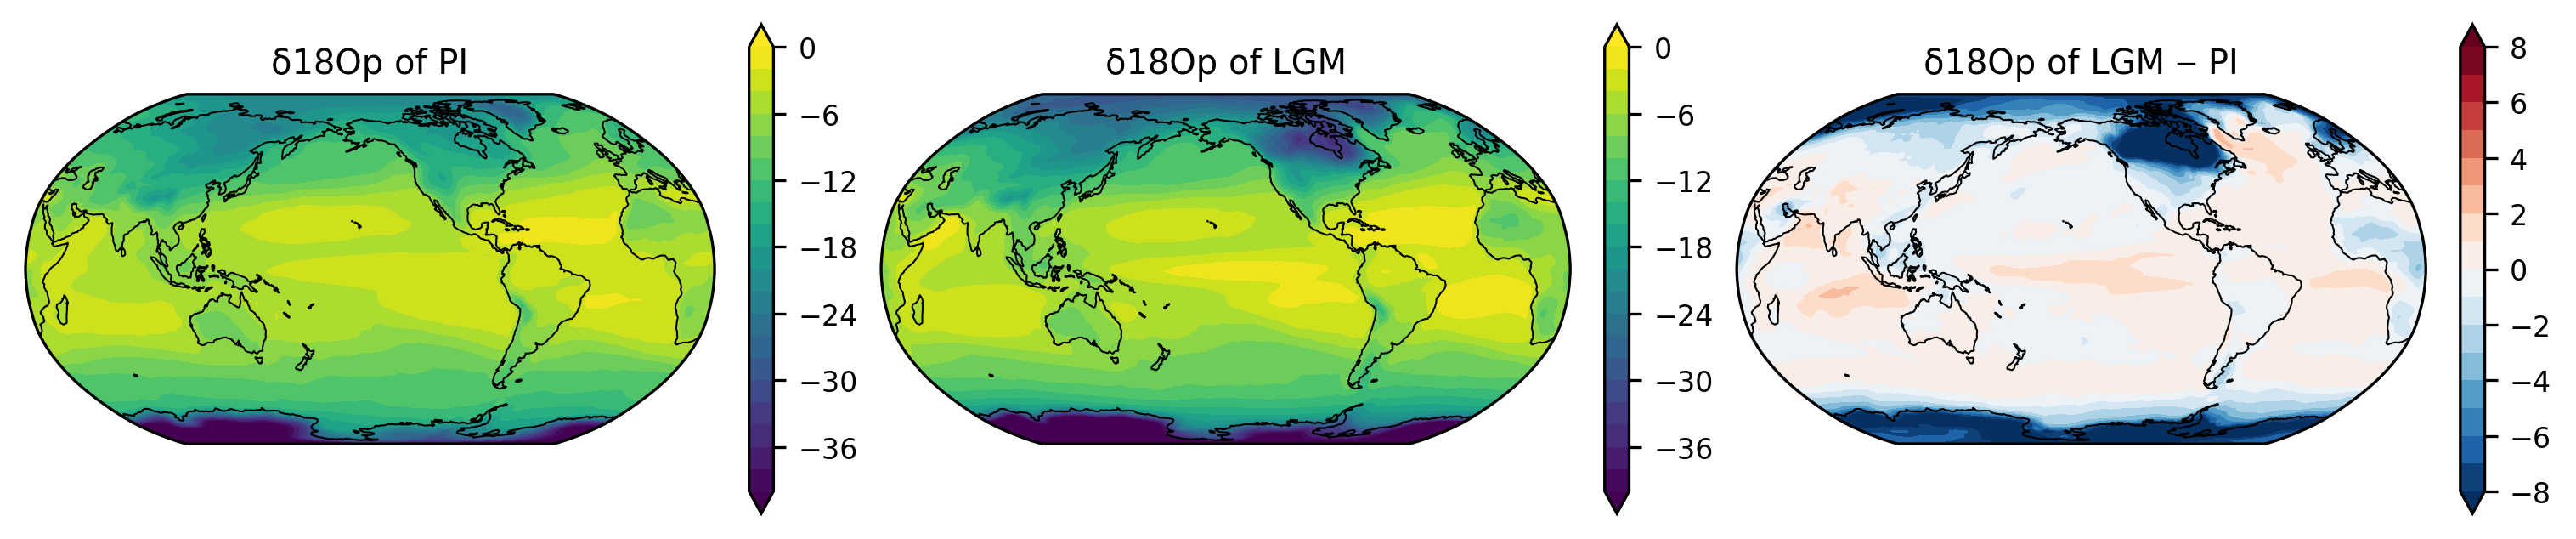

In [10]:
fig, axes = plt.subplots(1, 3,
                         figsize=(10, 2),
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=210)},
                         constrained_layout=True)
axes = axes.ravel()

lon = d18Op_pre.lon
lat = d18Op_pre.lat

ax = axes[0]
var_new, lon_new = add_cyclic_point(d18Op_pre, lon)
p0 = ax.contourf(lon_new, lat, var_new,
                 levels=np.linspace(-40, 0, 21),
                 extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p0, ax=ax)
ax.set_title("δ18Op of PI")

ax = axes[1]
var_new, lon_new = add_cyclic_point(d18Op_lgm, lon)
p1 = ax.contourf(lon_new, lat, var_new,
                 levels=np.linspace(-40, 0, 21),
                 extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p1, ax=ax)
ax.set_title("δ18Op of LGM")

ax = axes[2]
var_diff = d18Op_lgm - d18Op_pre
var_new, lon_new = add_cyclic_point(var_diff, lon)

p2 = ax.contourf(lon_new, lat, var_new,
                 cmap='RdBu_r',
                 levels=np.linspace(-8, 8, 17),
                 extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p2, ax=ax)
ax.set_title("δ18Op of LGM ‒ PI")

for ax in axes:
    ax.set_global()
    ax.coastlines(linewidth=0.5)

---
## Plot AMOC from iTraCE and compare with McManus et al. 2004
- TraCE data is directly accessible on NCAR machines: `/glade/campaign/cesm/community/palwg/TraCE/TraCE-Main`

In [11]:
file = '/glade/campaign/cesm/community/palwg/TraCE/TraCE-Main/ocn/proc/tavg/decadal/trace.01-36.22000BP.pop.MOC.22000BP_decavg_400BCE.nc'

ds = xr.open_dataset(file)
ds

<xarray.Dataset> Size: 49MB
Dimensions:               (nlat: 116, nlon: 100, time: 2204, transport_reg: 2,
                           moc_comp: 1, moc_z: 26, lat_aux_grid: 105, z_t: 25,
                           z_w: 25, transport_comp: 3)
Coordinates:
    TLAT                  (nlat, nlon) float32 46kB ...
    TLONG                 (nlat, nlon) float32 46kB ...
    ULAT                  (nlat, nlon) float32 46kB ...
    ULONG                 (nlat, nlon) float32 46kB ...
  * lat_aux_grid          (lat_aux_grid) float32 420B -80.26 -78.73 ... 90.0
    moc_components        (moc_comp) |S256 256B ...
  * moc_z                 (moc_z) float32 104B 0.0 800.0 ... 4.503e+05 5e+05
  * time                  (time) float64 18kB -22.0 -21.99 -21.98 ... 0.02 0.03
    transport_regions     (transport_reg) |S256 512B ...
  * z_t                   (z_t) float32 100B 400.0 1.222e+03 ... 4.751e+05
  * z_w                   (z_w) float32 100B 0.0 800.0 ... 4.007e+05 4.503e+05
Dimensions without coordinates: nlat, nlon, transport_reg, moc_comp,
                                transport_comp
Data variables: (12/51)
    ANGLE                 (nlat, nlon) float32 46kB ...
    ANGLET                (nlat, nlon) float32 46kB ...
    DXT                   (nlat, nlon) float32 46kB ...
    DXU                   (nlat, nlon) float32 46kB ...
    DYT                   (nlat, nlon) float32 46kB ...
    DYU                   (nlat, nlon) float32 46kB ...
    ...                    ...
    sea_ice_salinity      float64 8B ...
    sflux_factor          float64 8B ...
    sound                 float64 8B ...
    stefan_boltzmann      float64 8B ...
    transport_components  (transport_comp) |S256 768B ...
    vonkar                float64 8B ...
Attributes:
    title:                     b30.22_0kaDVT
    contents:                  Diagnostic and Prognostic Variables
    source:                    POP, the NCAR/CSM Ocean Component
    revision:                   $Name: ccsm3_0_1_beta22 $
    calendar:                  All years have exactly  365 days.
    conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    start_time:                This dataset was created on 2007-07-29 at 23:1...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    history:                   Fri Nov  8 22:51:40 2013: /glade/apps/opt/nco/...
    nco_openmp_thread_number:  1
    NCO:                       4.3.2

### Meridional Overturning Circulation is `MOC`, a 5-dimentional variable
- Dimension `transport_reg` has two values, 0 or 1, which means MOC value for the Global Ocean or the Atlantic Ocean, respectively. The corresponding coordinate `transport_regions` has the full names: (1) Global Ocean - Marginal Seas and (2) Atlantic Ocean + Labrador Sea + GIN Sea + Arctic Ocean.
- Dimension `moc_comp` has one value, 0, which means that the MOC values are the total transport. Note that potentially the model could write out more components: such as  (1) Total, (2) Eulerian-Mean Advection, and (3) Eddy-Induced Advection (bolus) + Diffusion. See the corresponding coordiname `moc_components` to see more.
- Dimension `moc_z` is the depth in centimeter.
- Dimension `lat_aux_grid` is the latitude in degrees north.

In [12]:
ds.MOC

<xarray.DataArray 'MOC' (time: 2204, transport_reg: 2, moc_comp: 1, moc_z: 26,
                         lat_aux_grid: 105)> Size: 48MB
[12033840 values with dtype=float32]
Coordinates:
  * lat_aux_grid       (lat_aux_grid) float32 420B -80.26 -78.73 ... 88.38 90.0
    moc_components     (moc_comp) |S256 256B ...
  * moc_z              (moc_z) float32 104B 0.0 800.0 ... 4.503e+05 5e+05
  * time               (time) float64 18kB -22.0 -21.99 -21.98 ... 0.02 0.03
    transport_regions  (transport_reg) |S256 512B ...
Dimensions without coordinates: transport_reg, moc_comp
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sverdrups

In [13]:
ds.MOC.transport_reg.values

array([0, 1])

In [14]:
ds.transport_regions.values

array([b'Global Ocean - Marginal Seas',
       b'Atlantic Ocean + Labrador Sea + GIN Sea + Arctic Ocean'],
      dtype='|S256')

In [15]:
ds.MOC.moc_comp.values

array([0])

In [16]:
ds.transport_components.values

array([b'Total', b'Eulerian-Mean Advection',
       b'Eddy-Induced Advection (bolus) + Diffusion'], dtype='|S256')

### The left and right plots are the global mean and Atlantic MOC, respectively

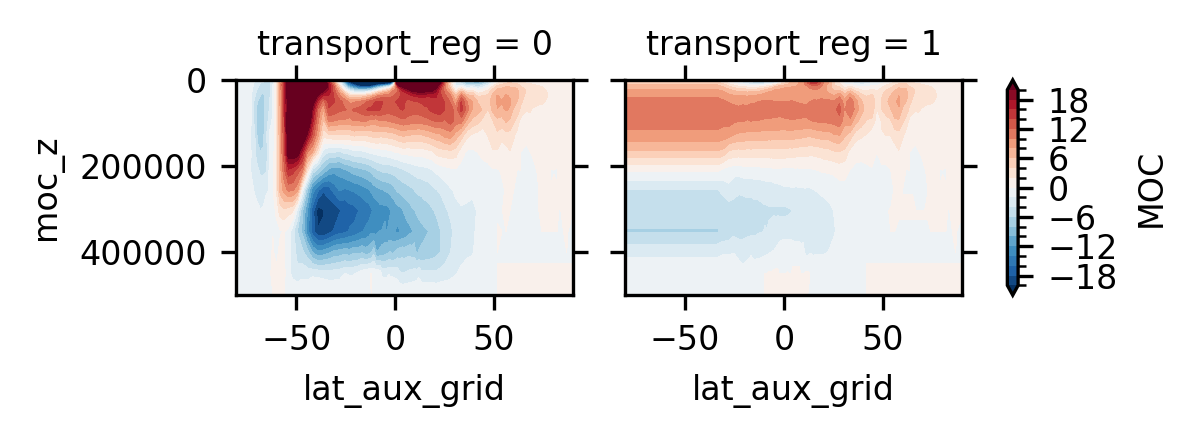

In [17]:
ds.MOC.isel(time=slice(0, 10), moc_comp=0).mean('time').plot.contourf(
    size=1.5, x='lat_aux_grid', y='moc_z', col='transport_reg',
    levels=np.linspace(-20, 20, 21))
plt.gca().invert_yaxis()

### Again, `transport_reg=1` means Atlantic and `moc_comp=0` means the total transport 

In [18]:
amoc = ds.MOC.isel(transport_reg=1, moc_comp=0)
amoc

<xarray.DataArray 'MOC' (time: 2204, moc_z: 26, lat_aux_grid: 105)> Size: 24MB
[6016920 values with dtype=float32]
Coordinates:
  * lat_aux_grid       (lat_aux_grid) float32 420B -80.26 -78.73 ... 88.38 90.0
    moc_components     |S256 256B ...
  * moc_z              (moc_z) float32 104B 0.0 800.0 ... 4.503e+05 5e+05
  * time               (time) float64 18kB -22.0 -21.99 -21.98 ... 0.02 0.03
    transport_regions  |S256 256B b'Atlantic Ocean + Labrador Sea + GIN Sea +...
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sverdrups

### We define AMOC time series as the maximum over the North Atlantic and beneath a depth of 500 m (to avoid the wind-drive cell)

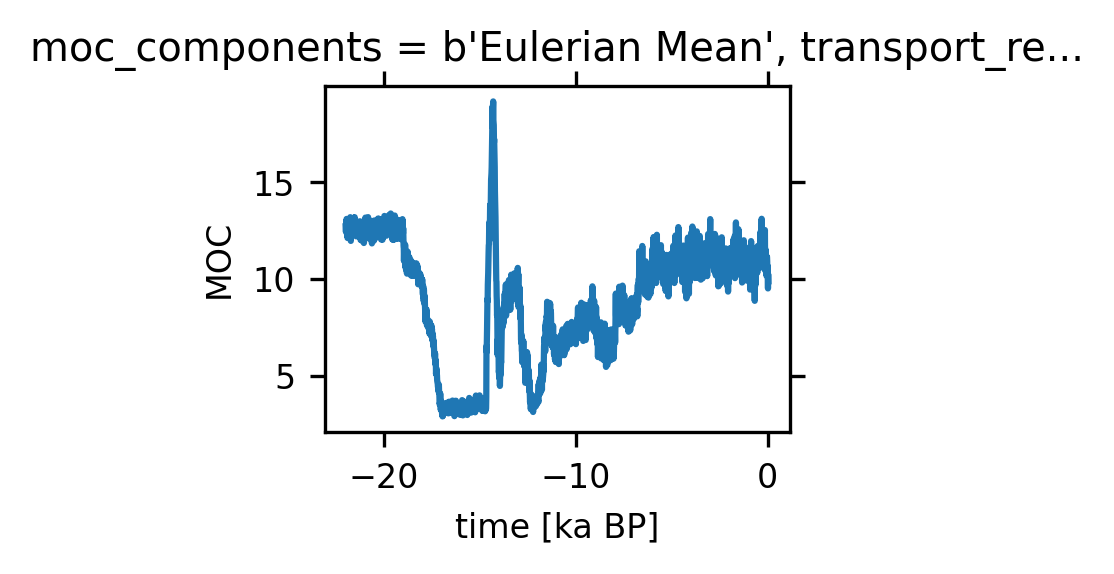

In [19]:
amoc_ts = amoc.sel(moc_z=slice(50000, 500000),
                   lat_aux_grid=slice(0, 90)).max(('moc_z', 'lat_aux_grid'))
amoc_ts.plot(size=1.5)

### Load the McManus et al. (2004) data from NOAA

In [20]:
McManus04 = 'https://www.ncei.noaa.gov/pub/data/paleo/paleocean/sediment_files/complete/o326-gc5-tab.txt'
pa_th = pd.read_table(McManus04, header=37)

# Replace missing values
pa_th = pa_th[pa_th["pa/th232"] != -999].reset_index(drop=True)
pa_th.head()

,depth,calyrBP,pa/th232,pa/th232.err,pa/th238,pa/th238.err,d18Og.infla,Unnamed: 7
0,-999,100,0.054,0.002,0.055,0.002,-999.00,NaN
1,-999,480,0.054,0.002,0.054,0.002,-999.00,NaN
2,-999,960,0.057,0.004,0.057,0.004,0.66,NaN
3,-999,1430,0.054,0.002,0.054,0.002,-999.00,NaN
4,-999,1910,0.055,0.002,0.055,0.002,0.63,NaN


In [21]:
# Change the time to be consistent with TraCE
pa_th['time'] = pa_th['calyrBP '] / -1000.0
pa_th.head()

,depth,calyrBP,pa/th232,pa/th232.err,pa/th238,pa/th238.err,d18Og.infla,Unnamed: 7,time
0,-999,100,0.054,0.002,0.055,0.002,-999.00,NaN,-0.10
1,-999,480,0.054,0.002,0.054,0.002,-999.00,NaN,-0.48
2,-999,960,0.057,0.004,0.057,0.004,0.66,NaN,-0.96
3,-999,1430,0.054,0.002,0.054,0.002,-999.00,NaN,-1.43
4,-999,1910,0.055,0.002,0.055,0.002,0.63,NaN,-1.91


### Plot time series

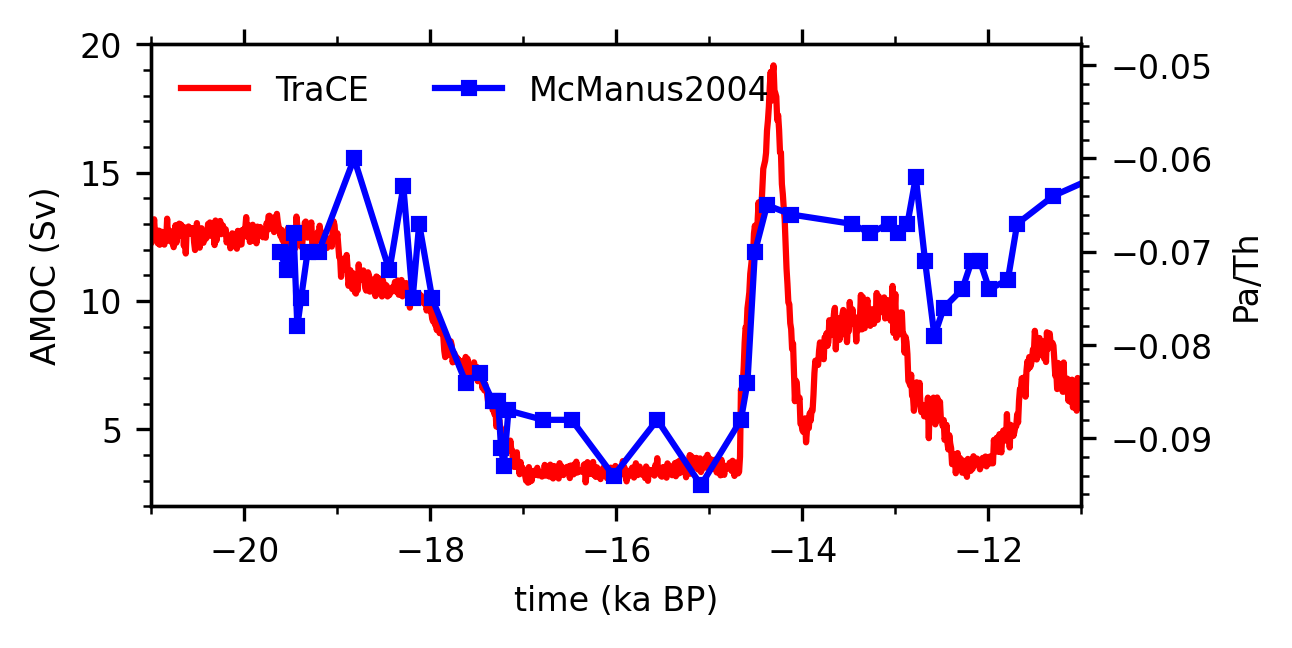

In [22]:
fig, ax = plt.subplots(figsize=(4, 2))

# Plot the AMOC time series in TraCE
ax.plot(amoc_ts.time, amoc_ts, 'red',
        label='TraCE')
ax.set_xlim([-21, -11])
ax.set_ylim([2, 20])
ax.set_xlabel('time (ka BP)')
ax.set_ylabel('AMOC (Sv)')
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))

# Plot the Pa/Th time series in McManus et al. (2004)
ax2 = ax.twinx()
ax2.plot(pa_th['time'], pa_th['pa/th238']*-1,
         'blue',
         marker='s', markersize=3,
         label='McManus2004')
ax2.set_ylabel('Pa/Th')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.002))

# Add a legend
lh1, ll1 = ax.get_legend_handles_labels()
lh2, ll2 = ax2.get_legend_handles_labels()
leg = ax.legend(lh1+lh2, ll1+ll2, frameon=False,
                loc='upper left',  ncol=2, fontsize=8)

---
## Postprocess annual mean δ18O from iTRACE
- Author: Jiang Zhu and Chengfei He

In [23]:
import warnings
warnings.filterwarnings("ignore")
import os
import xarray as xr
import numpy as np
from glob import glob
import re
from ncar_jobqueue import NCARCluster
from distributed import Client

### Request 10 CPUs

In [24]:
num_jobs = 10
cluster = NCARCluster(
    cores=num_jobs, memory='4GB',
    interface='mgt')
cluster.scale(jobs=num_jobs)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jiangzhu/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jiangzhu/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.18.206.88:33149,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jiangzhu/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [25]:
# Variables to extract
vars = ['PRECRC_H216Or', 'PRECSC_H216Os', 'PRECRL_H216OR', 'PRECSL_H216OS',
        'PRECRC_H218Or', 'PRECSC_H218Os', 'PRECRL_H218OR', 'PRECSL_H218OS',
        'TS', 'TREFHT']

# Path on RDA
path = '/glade/campaign/collections/rda/data/d651022/atm/proc/tseries/month_1/'

# iTRACE cases
prefixes = [
    'b.e13.Bi1850C5.f19_g16.20ka.itrace.ice_ghg_orb.01',
    'b.e13.Bi1850C5.f19_g16.20ka.itrace.ice_ghg_orb_wtr.01',
    'b.e13.Bi1850C5.f19_g16.18ka.itrace.ice_ghg_orb_wtr.03',
    'b.e13.Bi1850C5.f19_g16.17ka.itrace.ice_ghg_orb_wtr.01',
    'b.e13.Bi1850C5.f19_g16.16ka.itrace.ice_ghg_orb_wtr.01',
    'b.e13.Bi1850C5.f19_g16.15ka.itrace.ice_ghg_orb_wtr.03',
    'b.e13.Bi1850C5.f19_g16.14ka.itrace.ice_ghg_orb_wtr.01',
    'b.e13.Bi1850C5.f19_g16.13ka.itrace.ice_ghg_orb_wtr.02',
    'b.e13.Bi1850C5.f19_g16.12ka.itrace.ice_ghg_orb_wtr.05',
]

ds_list = []

for var in vars:

    files = glob(os.path.join(path, var, '*.nc'))

    # Find matching files
    matching_files = []
    for file_path in files:

        # Extract filename and base part
        filename = os.path.basename(file_path)

        # Check if any prefix matches the beginning of the filename
        for prefix in prefixes:

            # Create a simple pattern: prefix + any characters + .nc
            pattern = re.escape(prefix) + r'.*\.nc$'
            if re.search(pattern, filename):
                matching_files.append(file_path)
                break

    # remove ice_ghg_orb.100001-199912 that is not all forcing run
    case_excluded = glob(os.path.join(
        path, var,
        'b.e13.Bi1850C5.f19_g16.20ka.itrace.ice_ghg_orb.01.*.100001-199912.nc'))
    matching_files.remove(case_excluded[0])

    ds_var = xr.open_mfdataset(
        matching_files,
        concat_dim='time',
        combine='nested',
        data_vars='minimal',
        coords='minimal',
        compat='override',
        chunks={'time': 1200}
    )[var]

    ds_list.append(ds_var.sortby('time'))

ds = xr.merge(ds_list, compat='override')
ds['time'] = xr.cftime_range('-20000', periods=len(ds.time), freq='ME')

In [26]:
sorted(matching_files)

['/glade/campaign/collections/rda/data/d651022/atm/proc/tseries/month_1/TREFHT/b.e13.Bi1850C5.f19_g16.12ka.itrace.ice_ghg_orb_wtr.05.cam.h0.TREFHT.800001-899912.nc',
 '/glade/campaign/collections/rda/data/d651022/atm/proc/tseries/month_1/TREFHT/b.e13.Bi1850C5.f19_g16.13ka.itrace.ice_ghg_orb_wtr.02.cam.h0.TREFHT.700001-799912.nc',
 '/glade/campaign/collections/rda/data/d651022/atm/proc/tseries/month_1/TREFHT/b.e13.Bi1850C5.f19_g16.14ka.itrace.ice_ghg_orb_wtr.01.cam.h0.TREFHT.600001-699912.nc',
 '/glade/campaign/collections/rda/data/d651022/atm/proc/tseries/month_1/TREFHT/b.e13.Bi1850C5.f19_g16.15ka.itrace.ice_ghg_orb_wtr.03.cam.h0.TREFHT.500001-599912.nc',
 '/glade/campaign/collections/rda/data/d651022/atm/proc/tseries/month_1/TREFHT/b.e13.Bi1850C5.f19_g16.16ka.itrace.ice_ghg_orb_wtr.01.cam.h0.TREFHT.400001-499912.nc',
 '/glade/campaign/collections/rda/data/d651022/atm/proc/tseries/month_1/TREFHT/b.e13.Bi1850C5.f19_g16.17ka.itrace.ice_ghg_orb_wtr.01.cam.h0.TREFHT.300001-399912.nc',
 '/g

In [27]:
%%time

ds = calculate_d18Op(ds)

# Get the ammnau mean
# Resample the dataset ds by year-end (YE) along the time dimension, then compute the mean over each year.
ds_ann = ds[['d18O']].resample(time='YE').mean()

ds_ann.to_netcdf('b.e13.Bi1850C5.f19_g16.20ka.itrace.01.cam.h0.d18O.20-11ka.ann.nc')

CPU times: user 10.8 s, sys: 1.23 s, total: 12 s
Wall time: 3min 56s


In [28]:
cluster.close()